**Question 1** - Linear regression on price and demand data

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
!pip install gurobipy
import gurobipy as gp
from gurobipy import Model, GRB, quicksum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 35.3 MB/s eta 0:00:00


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving price_demand_data.csv to price_demand_data.csv


In [ ]:
data = pd.read_csv("price_demand_data.csv")  # use your file name
data.head()


,price,demand
0,1.05,283
1,0.86,771
2,1.21,185
3,0.94,531
4,0.76,1002


#### Data preperation and linear fit of demand

In [ ]:
import statsmodels.api as sm

# Prepare data
X = data[['price']]
X = sm.add_constant(X)     # adds β0 manually
y = data['demand']

# Fit OLS model
model = sm.OLS(y, X).fit()

# Display full regression table
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 demand   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     159.3
Date:                Sun, 30 Nov 2025   Prob (F-statistic):           3.51e-22
Time:                        23:01:27   Log-Likelihood:                -636.17
No. Observations:                  99   AIC:                             1276.
Df Residuals:                      97   BIC:                             1282.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1924.7175    111.334     17.288      0.0

#### Visulaization of fitted demand

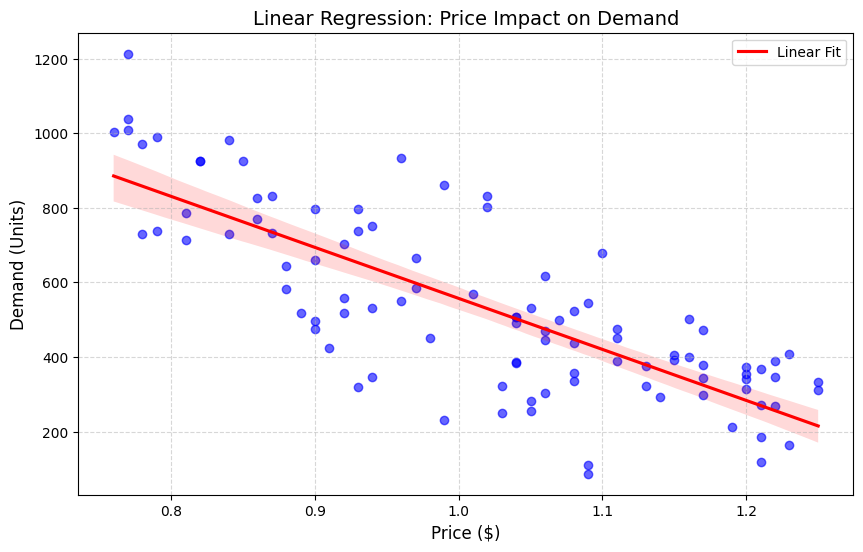

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# sns.regplot automatically fits the linear regression and plots it
sns.regplot(x='price', y='demand', data=data,
            scatter_kws={'color': 'blue', 'alpha': 0.6},
            line_kws={'color': 'red', 'label': 'Linear Fit'})

plt.title('Linear Regression: Price Impact on Demand', fontsize=14)
plt.xlabel('Price ($)', fontsize=12)
plt.ylabel('Demand (Units)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

**Question 2** - generating demand data

In [ ]:
beta0 = model.params['const']
beta1 = model.params['price']

print("beta0 =", beta0)
print("beta1 =", beta1)
residuals = model.resid
residuals.describe()

beta0 = 1924.717543529109
beta1 = -1367.7125241625986


,0
count,9.900000e+01
mean,1.791429e-13
std,1.502125e+02
min,-3.469109e+02
25%,-1.045475e+02
50%,1.289174e+01
75%,1.002192e+02
max,3.414211e+02


Once we have $\beta_{0}$ and $\beta_{1}$ we treat the residuals as the randomnes and construct demand for any price p as $D_{i} = \beta_{0}+\beta_{1}*p+\epsilon_{i}$
Given c = 0.5, g = 0.75, t = 0.15 and price fixed at p = 1.

In [ ]:
c = 0.5
g = 0.75
t = 0.15
p = 1.0

In [ ]:
#We produce the series with scenario demands Di(1) as possible realizations of demand
demand_p1 = beta0 + beta1 * p + residuals
demand_p1.head()

,0
0,351.385626
1,579.520247
2,472.219630
3,448.937249
4,673.748994


In [ ]:
#Prepare the data for Gurobi

D_vals = demand_p1.values   # numpy array of D_i(1)
n = len(D_vals)

#### Visulaization of demand destribution

--- Demand Metrics for Price p=$1.00 ---
count     99.000000
mean     557.005019
std      150.212535
min      210.094127
25%      452.457495
50%      569.896755
75%      657.224189
max      898.426119
dtype: float64


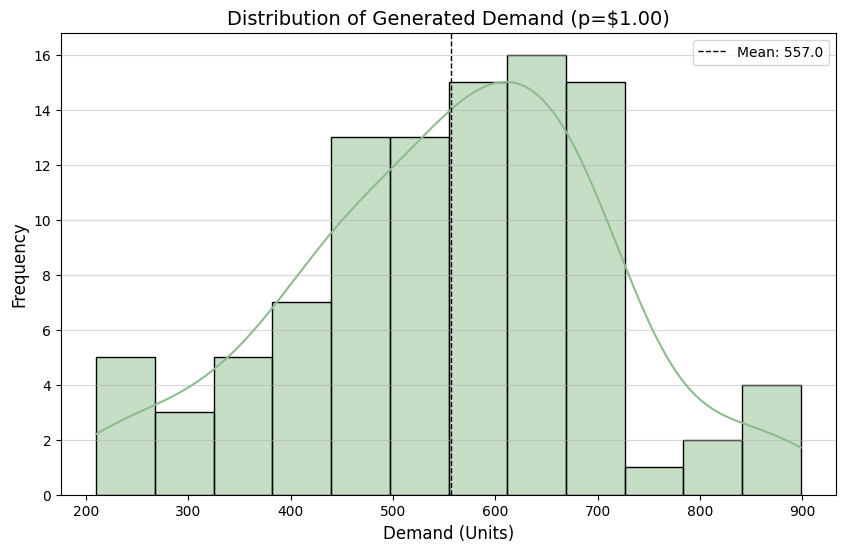

In [ ]:
# 1. Print Metrics (Min, Max, Mean, Std Dev, etc.)
print("--- Demand Metrics for Price p=$1.00 ---")
print(demand_p1.describe())

# 2. Graph the Distribution of Demand
plt.figure(figsize=(10, 6))
sns.histplot(demand_p1, kde=True, color='darkseagreen', bins=12)
plt.title('Distribution of Generated Demand (p=$1.00)', fontsize=14)
plt.xlabel('Demand (Units)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(demand_p1.mean(), color='k', linestyle='dashed', linewidth=1, label=f'Mean: {demand_p1.mean():.1f}')
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show()

**Question 3**

We extend the model to include constraints

$$
u_{i}\approx (D_{i}-q)^+ \quad \text{and} \quad v_{i}\approx (q-D_{i})^+
$$

In [ ]:
#Create the model and variables
m_lp = Model("NV_p1")
q = m_lp.addVar(lb=0, vtype=GRB.CONTINUOUS, name="q")
u = []
v = []
for i in range(n):
    u.append(m_lp.addVar(lb=0,vtype=GRB.CONTINUOUS,name=f"u_{i}"))
    v.append(m_lp.addVar(lb=0,vtype=GRB.CONTINUOUS,name=f"v_{i}"))

Restricted license - for non-production use only - expires 2027-11-29


In [ ]:
#Add constraints to enforce the plus-structure
for i in range(n):
    m_lp.addConstr(u[i]>=D_vals[i]-q,name=f"shortage_{i}")
    m_lp.addConstr(v[i]>=q-D_vals[i],name=f"excess_{i}")

In [ ]:
#Set the objective

m_lp.setObjective(
    (1.0/n)*quicksum(
        p*D_vals[i]-c*q-g*u[i]-t*v[i]
        for i in range(n)
    ),
    GRB.MAXIMIZE
)


In [ ]:
m_lp.optimize()
if m_lp.status == GRB.OPTIMAL:
    q_star = q.X
    print("Optimal q* (p=1)", q_star)
    print("Expected profit:", m_lp.objVal)

Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 198 rows, 199 columns and 396 nonzeros (Max)
Model fingerprint: 0x71a6161a
Model has 199 linear objective coefficients and an objective constant of -5.5700501936651051e+02
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-03, 5e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+02, 9e+02]
Presolve time: 0.01s
Presolved: 198 rows, 199 columns, 396 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.5700502e+02   5.514350e+04   0.000000e+00      0s
      99    2.3148367e+02   0.000000e+00   0.000000e+00      0s

Solved in 99 iterations and 0.02 seconds (0.00 work units)
Optimal objective  2.314836666e+02
Optimal q* (p=1) 471.86537959089355
Expected profit: 23

**Question 4**

The price - demand function is introduced into the model
$$
D_i(p) = \beta_0 + \beta_1 p + \epsilon_i.
$$

In [ ]:
#We precomputed the residuals as a numpy array
eps_vals = residuals.values   # ε_i from Q1
n = len(eps_vals)

In [ ]:
m_qp = Model("NV_price_quantity")

In [ ]:
q_var = m_qp.addVar(lb=0,vtype=GRB.CONTINUOUS,name="q")
p_var = m_qp.addVar(lb=0,vtype=GRB.CONTINUOUS,name="p")

In [ ]:
p_var.lb = 0.5
p_var.ub = 2.0

In [ ]:
u_qp = []
v_qp = []
for i in range(n):
    u_qp.append(m_qp.addVar(lb=0,vtype=GRB.CONTINUOUS,name=f"u_{i}"))
    v_qp.append(m_qp.addVar(lb=0,vtype=GRB.CONTINUOUS,name=f"u_{i}"))

In [ ]:
#Adding constraints using Di(p)
for i in range(n):
    Di_p = beta0+beta1*p_var+eps_vals[i]
    m_qp.addConstr(u_qp[i]>=Di_p-q_var,name=f"shortage_{i}")
    m_qp.addConstr(v_qp[i]>=q_var-Di_p,name=f"excess_{i}")

The objective function thus becomes:

$$
\max_q \; \frac{1}{n}\sum_{i=1}^n
\left(
pD_i - qc - g(D_i-q)^+ - t(q-D_i)^+
\right).
$$

In [ ]:
m_qp.setObjective(
    (1.0/n)*quicksum(
        p_var*(beta0+beta1*p_var+eps_vals[i])-c*q_var-g*u_qp[i]-t*v_qp[i] for i in range(n)
    ),
    GRB.MAXIMIZE
)

In [ ]:
m_qp.optimize()
if m_qp.status == GRB.OPTIMAL:
    q_star_qp = q_var.X
    p_star_qp = p_var.X
    print("Optimal price p*:",p_star_qp)
    print("Optimal quantity q*:",q_star_qp)
    print("Expected profit:",m_qp.objVal)

Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 198 rows, 200 columns and 594 nonzeros (Max)
Model fingerprint: 0xa6b016d0
Model has 200 linear objective coefficients
Model has 1 quadratic objective term
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [2e-03, 2e+03]
  QObjective range [3e+03, 3e+03]
  Bounds range     [5e-01, 2e+00]
  RHS range        [2e+03, 2e+03]
Presolve time: 0.01s
Presolved: 198 rows, 200 columns, 594 nonzeros
Presolved model has 1 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.950e+04
 Factor NZ  : 1.970e+04
 Factor Ops : 2.607e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     

**Question 6**

Runs one bootstrap iteration:
  1. Resample the dataset with replacement
  2. Fit regression (OLS)
  3. Solve the QP from Question 4 using new betas and residuals
  4. Return optimal p*, q*, and expected profit

In [ ]:
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression
import numpy as np

def run_bootstrap_simulation(df_original,seed):

    df_sample = resample(df_original, replace=True,
                         n_samples=len(df_original),
                         random_state=seed)

    X = df_sample[['price']]
    y = df_sample['demand']
    reg = LinearRegression().fit(X, y)

    b0 = reg.intercept_
    b1 = reg.coef_[0]

    # residuals = y - predicted
    residuals = (y - reg.predict(X)).values
    n = len(residuals)

    m = Model("Bootstrap_QP")
    m.setParam("OutputFlag", 0)  # silence Gurobi output

    # Decision variables
    p = m.addVar(lb=0.5, ub=2.0, vtype=GRB.CONTINUOUS, name="p")  # price
    q = m.addVar(lb=0.0, vtype=GRB.CONTINUOUS, name="q")          # quantity

    # Shortage & excess variables
    u = m.addVars(n, lb=0.0, vtype=GRB.CONTINUOUS, name="u")
    v = m.addVars(n, lb=0.0, vtype=GRB.CONTINUOUS, name="v")

    # Parameters
    c, g, t = 0.5, 0.75, 0.15

    for i in range(n):
        Di_p = b0 + b1 * p + residuals[i]
        m.addConstr(u[i] >= Di_p - q)
        m.addConstr(v[i] >= q - Di_p)

    obj = (1.0 / n) * quicksum(
        p * (b0 + b1*p + residuals[i])   # revenue term: p * D_i(p)
        - c*q                            # base production cost
        - g*u[i]                         # rush printing cost
        - t*v[i]                         # disposal cost
        for i in range(n)
    )

    m.setObjective(obj, GRB.MAXIMIZE)
    m.optimize()

    if m.status == GRB.OPTIMAL:
        return float(p.X), float(q.X), float(m.objVal)
    else:
        return None, None, None


In [ ]:
p_star, q_star, prof = run_bootstrap_simulation(data,seed=123)
print("Single bootstrap: ")
print('Optimal_Price:', p_star)
print('Optimal_Quantity:',q_star)
print('Expected_Profit:',prof)


Single bootstrap: 
Optimal_Price: 0.9482729457674167
Optimal_Quantity: 521.2774799570067
Expected_Profit: 237.49942710427138


**Question 7**

In [ ]:
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression
import numpy as np

# Function to run one iteration of the bootstrap
def run_bootstrap_simulation(df_original,seed):
    # 1. BOOTSTRAP: Sample n rows from original data with replacement
    df_sample = resample(df_original, n_samples=len(df_original),random_state=seed)

    # 2. REGRESSION (From Q1 logic)
    X = df_sample[['price']]
    y = df_sample['demand']
    reg = LinearRegression().fit(X, y)

    b0 = reg.intercept_
    b1 = reg.coef_[0]
    residuals = (y - reg.predict(X)).values
    n = len(residuals)

    # 3. GUROBI OPTIMIZATION (Adapted from Q4 FS logic)
    m = Model("Bootstrap_QP")
    m.setParam('OutputFlag', 0) # Silence output for loop

    # Variables
    p = m.addVar(lb=0.5, ub=2.0, vtype=GRB.CONTINUOUS) # Keeping FS's safe bounds
    q = m.addVar(lb=0.0, vtype=GRB.CONTINUOUS)
    u = m.addVars(n, lb=0.0, vtype=GRB.CONTINUOUS)
    v = m.addVars(n, lb=0.0, vtype=GRB.CONTINUOUS)

    # Constants
    c, g, t = 0.5, 0.75, 0.15

    # Constraints & Objective
    # Note: We must recreate the logic inside the function scope
    for i in range(n):
        # Demand function D(p) = b0 + b1*p + residual_i
        D_expr = b0 + b1*p + residuals[i]

        m.addConstr(u[i] >= D_expr - q)
        m.addConstr(v[i] >= q - D_expr)

    obj = (1.0/n) * quicksum(
        p * (b0 + b1*p + residuals[i]) - c*q - g*u[i] - t*v[i]
        for i in range(n)
    )

    m.setObjective(obj, GRB.MAXIMIZE)
    m.optimize()

    if m.status == GRB.OPTIMAL:
        return p.X, q.X, m.objVal
    else:
        return None, None, None

In [ ]:
results_p = []
results_q = []
results_profit = []

for k in range(500):
    # Each iteration gets its own seed for reproducibility
    p_opt, q_opt, prof = run_bootstrap_simulation(data, seed=k)

    if p_opt is not None:
        results_p.append(p_opt)
        results_q.append(q_opt)
        results_profit.append(prof)

    if k % 10 == 0:
        print(f"Iteration {k} done...")

Iteration 0 done...
Iteration 10 done...
Iteration 20 done...
Iteration 30 done...
Iteration 40 done...
Iteration 50 done...
Iteration 60 done...
Iteration 70 done...
Iteration 80 done...
Iteration 90 done...
Iteration 100 done...
Iteration 110 done...
Iteration 120 done...
Iteration 130 done...
Iteration 140 done...
Iteration 150 done...
Iteration 160 done...
Iteration 170 done...
Iteration 180 done...
Iteration 190 done...
Iteration 200 done...
Iteration 210 done...
Iteration 220 done...
Iteration 230 done...
Iteration 240 done...
Iteration 250 done...
Iteration 260 done...
Iteration 270 done...
Iteration 280 done...
Iteration 290 done...
Iteration 300 done...
Iteration 310 done...
Iteration 320 done...
Iteration 330 done...
Iteration 340 done...
Iteration 350 done...
Iteration 360 done...
Iteration 370 done...
Iteration 380 done...
Iteration 390 done...
Iteration 400 done...
Iteration 410 done...
Iteration 420 done...
Iteration 430 done...
Iteration 440 done...
Iteration 450 done...

In [ ]:
# Create the DataFrame from lists
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

results_df = pd.DataFrame({
    'Optimal_Price': results_p,
    'Optimal_Quantity': results_q,
    'Expected_Profit': results_profit
})

In [ ]:
# After creating results_df, add:
print("\n=== Bootstrap Results Summary ===")
print(results_df.describe())
print("\nStandard Errors:")
print(f"Price SE: {results_df['Optimal_Price'].std():.4f}")
print(f"Quantity SE: {results_df['Optimal_Quantity'].std():.4f}")
print(f"Profit SE: {results_df['Expected_Profit'].std():.4f}")

print("\n95% Confidence Intervals:")
print(f"Price: [{results_df['Optimal_Price'].quantile(0.025):.2f}, {results_df['Optimal_Price'].quantile(0.975):.2f}]")
print(f"Quantity: [{results_df['Optimal_Quantity'].quantile(0.025):.2f}, {results_df['Optimal_Quantity'].quantile(0.975):.2f}]")
print(f"Profit: [{results_df['Expected_Profit'].quantile(0.025):.2f}, {results_df['Expected_Profit'].quantile(0.975):.2f}]")


=== Bootstrap Results Summary ===
       Optimal_Price  Optimal_Quantity  Expected_Profit
count     500.000000        500.000000       500.000000
mean        0.954655        536.973188       235.545037
std         0.013540         33.400523         9.163847
min         0.917917        439.441605       211.836635
25%         0.945672        514.030634       229.820751
50%         0.953615        530.975035       235.107442
75%         0.963402        560.827072       241.244396
max         1.001894        671.388311       267.729745

Standard Errors:
Price SE: 0.0135
Quantity SE: 33.4005
Profit SE: 9.1638

95% Confidence Intervals:
Price: [0.93, 0.98]
Quantity: [473.92, 605.05]
Profit: [216.69, 254.64]


**Histogram for optimal price**

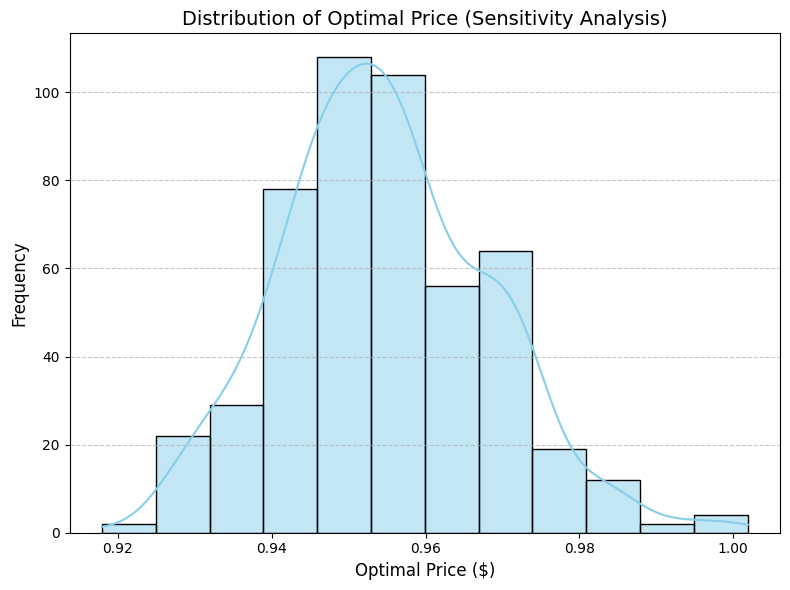

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(results_df['Optimal_Price'], kde=True, color='skyblue', edgecolor='black',bins =12)
plt.title('Distribution of Optimal Price (Sensitivity Analysis)', fontsize=14)
plt.xlabel('Optimal Price ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Histogram of Optimal Quantity

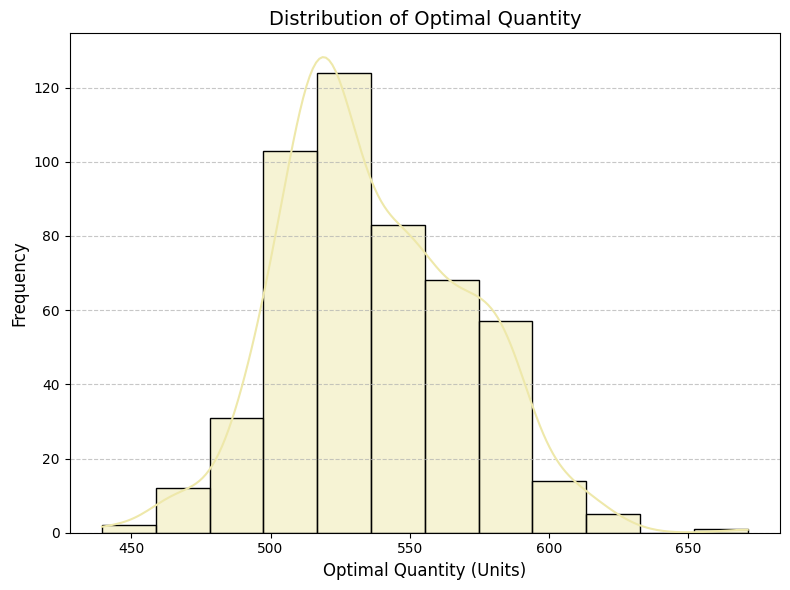

In [ ]:
plt.figure(figsize=(8, 6))

sns.histplot(results_df['Optimal_Quantity'], kde=True, color='palegoldenrod',edgecolor='black', bins=12 )
plt.title('Distribution of Optimal Quantity', fontsize=14)
plt.xlabel('Optimal Quantity (Units)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Histogram of Expected Profit

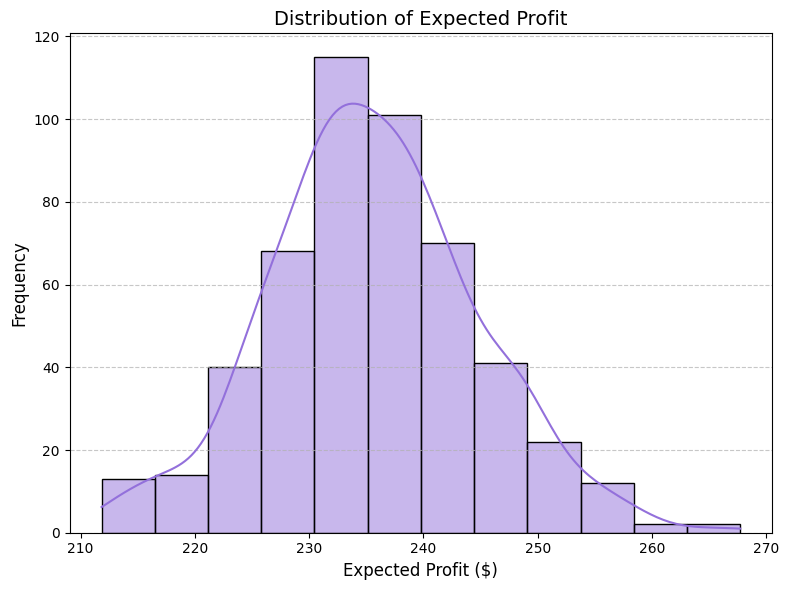

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(results_df['Expected_Profit'], kde=True, color='mediumpurple', edgecolor='black',bins =12)
plt.title('Distribution of Expected Profit', fontsize=14)
plt.xlabel('Expected Profit ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### The Joint Scatterplot

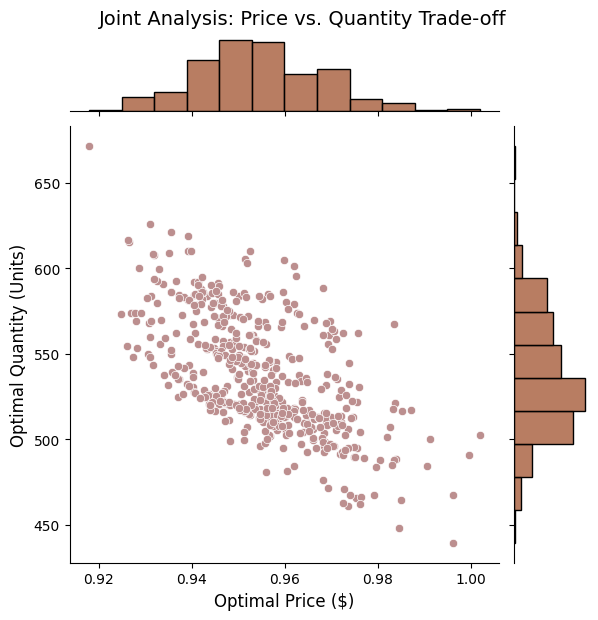

In [ ]:
g = sns.jointplot(
    data=results_df,
    x="Optimal_Price",
    y="Optimal_Quantity",
    kind="scatter",
    color="rosybrown",
    marginal_kws=dict(bins=12, fill=True, color="sienna")
)

g.fig.suptitle("Joint Analysis: Price vs. Quantity Trade-off", y=1.02, fontsize=14)
g.set_axis_labels("Optimal Price ($)", "Optimal Quantity (Units)", fontsize=12)
plt.show()